# Lecture 5 Extension (China A-shares): BYD vs SAIC - Simple Financial Statement Comparison

This notebook provides a minimal, statement-based comparison between two China A-share automakers:
- BYD Co., Ltd. (002594.SZ)
- SAIC Motor Corporation (600104.SH)

**Data source**: AkShare (open-source) with publicly available financial statement data from Eastmoney.

The focus is on four core fundamentals (annual, full-year values):
- Total Assets
- Revenue
- Net Profit (parent company)
- Operating Cash Flow

All charts plot the two firms on the same axes to highlight cross-firm differences in scale and trend.

In [1]:
import akshare as ak
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

BYD = 'sz002594'
SAIC = 'sh600104'

CACHE_DIR = Path('data/china_auto')
CACHE_DIR.mkdir(parents=True, exist_ok=True)

# BYD: solid line; SAIC: dashed line
LINESTYLE = {BYD: '-', SAIC: '--'}
LABEL = {BYD: 'BYD', SAIC: 'SAIC'}


In [2]:
def load_or_fetch(symbol: str, kind: str, fetch_fn):
    path = CACHE_DIR / f"{symbol}_{kind}.csv.gz"
    if path.exists():
        return pd.read_csv(path, compression='gzip')
    df = fetch_fn(symbol=symbol)
    df.to_csv(path, index=False, compression='gzip')
    return df


def annual_financials(symbol: str) -> pd.DataFrame:
    profit = load_or_fetch(symbol, 'profit_sheet', ak.stock_profit_sheet_by_report_em)
    balance = load_or_fetch(symbol, 'balance_sheet', ak.stock_balance_sheet_by_report_em)
    cash = load_or_fetch(symbol, 'cash_flow_sheet', ak.stock_cash_flow_sheet_by_report_em)

    for df in (profit, balance, cash):
        df['REPORT_DATE'] = pd.to_datetime(df['REPORT_DATE'], errors='coerce')
        df.sort_values('REPORT_DATE', inplace=True)
        df.drop_duplicates('REPORT_DATE', keep='last', inplace=True)

    # Annual reports correspond to year-end (December 31)
    profit = profit[profit['REPORT_DATE'].dt.strftime('%m-%d').eq('12-31')]
    balance = balance[balance['REPORT_DATE'].dt.strftime('%m-%d').eq('12-31')]
    cash = cash[cash['REPORT_DATE'].dt.strftime('%m-%d').eq('12-31')]

    net_profit_col = 'PARENTNETPROFIT' if 'PARENTNETPROFIT' in profit.columns else 'NETPROFIT'

    out = pd.concat(
        [
            balance.set_index('REPORT_DATE')['TOTAL_ASSETS'].rename('Total Assets'),
            profit.set_index('REPORT_DATE')['TOTAL_OPERATE_INCOME'].rename('Revenue'),
            profit.set_index('REPORT_DATE')[net_profit_col].rename('Net Profit'),
            cash.set_index('REPORT_DATE')['NETCASH_OPERATE'].rename('Operating Cash Flow'),
        ],
        axis=1,
    ).sort_index()

    out = out.apply(pd.to_numeric, errors='coerce')
    return out


byd = annual_financials(BYD)
saic = annual_financials(SAIC)

comparison = pd.concat({'BYD': byd, 'SAIC': saic}, axis=1)
comparison.tail(8)


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

BYD                                                  \
             Total Assets       Revenue    Net Profit Operating Cash Flow   
REPORT_DATE                                                                 
2017-12-31   1.780994e+11  1.059147e+11  4.916936e+09        6.578825e+09   
2018-12-31   1.945711e+11  1.300547e+11  3.556193e+09        1.252291e+10   
2019-12-31   1.956416e+11  1.277385e+11  2.118857e+09        1.474101e+10   
2020-12-31   2.010173e+11  1.565977e+11  6.013963e+09        4.539267e+10   
2021-12-31   2.957801e+11  2.161424e+11  3.967266e+09        6.546668e+10   
2022-12-31   4.938606e+11  4.240606e+11  1.771310e+10        1.408377e+11   
2023-12-31   6.795477e+11  6.023154e+11  3.134407e+10        1.697250e+11   
2024-12-31   7.833559e+11  7.771025e+11  4.158794e+10        1.334539e+11   

                     SAIC                                                  
             Total Assets       Revenue    Net Profit Operating Cash Flow  
REPORT_DATE                                                                
2017-12-31   7.235331e+11  8.706394e+11  4.711610e+10        2.430107e+10  
2018-12-31   7.827698e+11  9.021941e+11  4.840466e+10        8.975655e+09  
2019-12-31   8.493333e+11  8.433244e+11  3.528891e+10        4.627185e+10  
2020-12-31   9.194148e+11  7.421325e+11  2.918805e+10        3.751794e+10  
2021-12-31   9.169227e+11  7.798458e+11  3.394176e+10        2.161574e+10  
2022-12-31   9.901074e+11  7.440629e+11  2.284265e+10        9.504540e+09  
2023-12-31   1.006650e+12  7.447051e+11  2.006044e+10        4.233442e+10  
2024-12-31   9.571434e+11  6.275899e+11  5.833321e+09        6.926779e+10

## Visualization

The charts below compare the two firms on the same axes.

- Amounts are displayed in **CNY billions**.
- BYD is shown with a solid line; SAIC is shown with a dashed line.

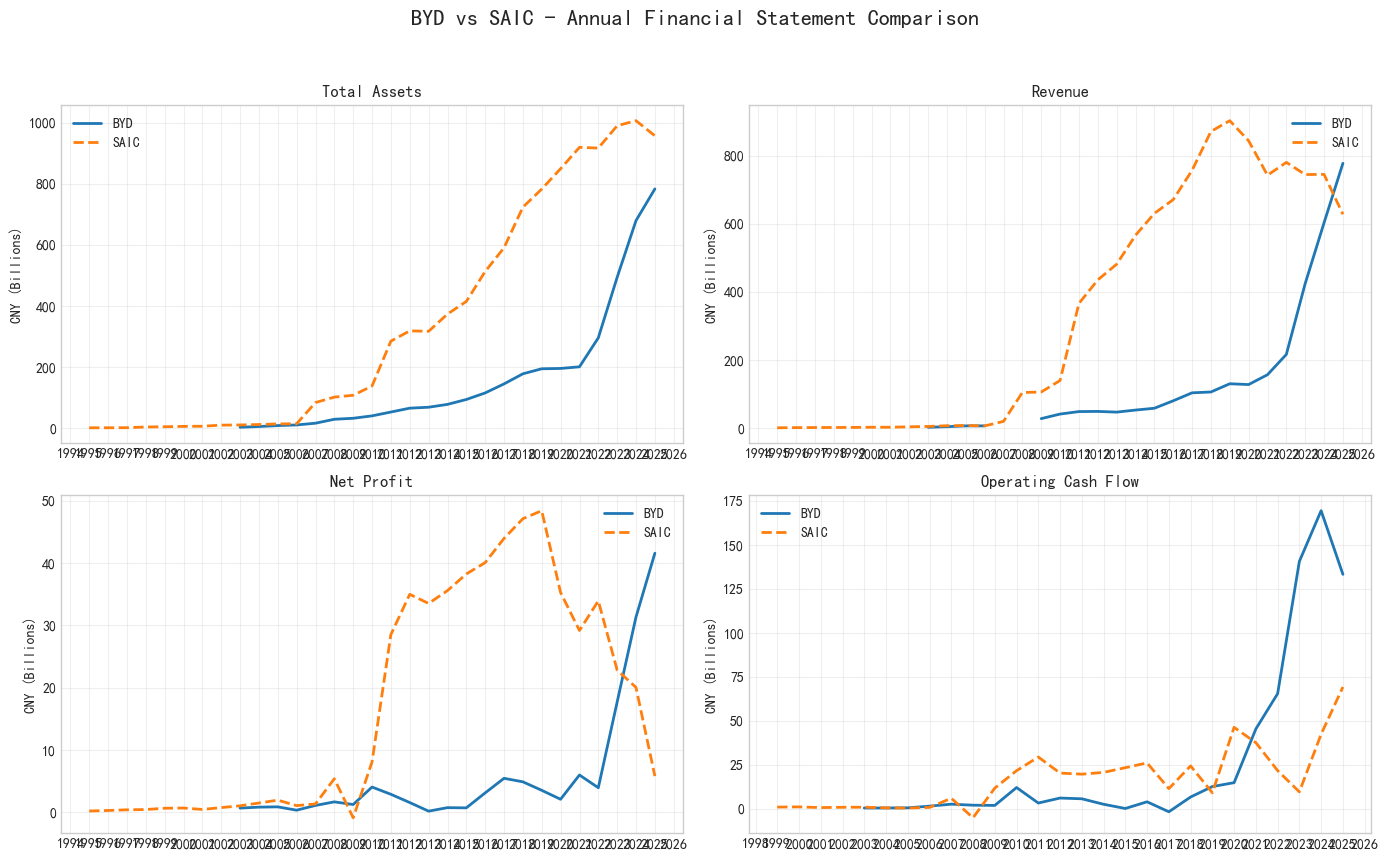

In [3]:
def plot_metric(ax, metric: str, ylabel: str, scale: float = 1e9):
    ax.plot(byd.index, byd[metric] / scale, linestyle=LINESTYLE[BYD], linewidth=2, label=LABEL[BYD])
    ax.plot(saic.index, saic[metric] / scale, linestyle=LINESTYLE[SAIC], linewidth=2, label=LABEL[SAIC])

    ax.set_title(metric, fontweight='bold')
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.legend(loc='best')


fig, axes = plt.subplots(2, 2, figsize=(14, 9))
fig.suptitle('BYD vs SAIC - Annual Financial Statement Comparison', fontsize=16, fontweight='bold')

plot_metric(axes[0, 0], 'Total Assets', 'CNY (Billions)')
plot_metric(axes[0, 1], 'Revenue', 'CNY (Billions)')
plot_metric(axes[1, 0], 'Net Profit', 'CNY (Billions)')
plot_metric(axes[1, 1], 'Operating Cash Flow', 'CNY (Billions)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
